In [1]:
from dask.distributed import Client, LocalCluster
client = Client()

/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34308 instead
  warnings.warn(


In [2]:
client

Client Scheduler: tcp://127.0.0.1:44196 Dashboard: http://127.0.0.1:34308/status,Cluster Workers: 9 Cores: 72 Memory: 0.98 TiB


In [27]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
import os
import gcm_filters
import xrft
from dask.diagnostics import ProgressBar
from rechunker import rechunk
import zarr

In [53]:
#u_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel.zarr',decode_cf=False)
#v_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel.zarr',decode_cf=False)
eta_merged = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_long.zarr')#,decode_cf=False)

eta_merged = eta_merged.isel(time=slice(1,1800))
#u_merged = u_merged.isel(time=slice(1,1800))
#v_merged = v_merged.isel(time=slice(1,1800))

#eta_merged = eta_merged.drop_vars('time')

In [24]:
#eta_mean = eta_merged.Eta.mean('time')
#eta_mean.to_dataset().to_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_mean.zarr', append_dim='time')
eta_mean = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_mean.zarr').Eta

In [55]:
#eta = eta_merged.Eta
#eta_nom = eta-eta_mean

In [56]:
#outdir='/swot/SUM03/spencer/swot_eta_nomean/'
#for i in range(0,1751):
#    if np.mod(i,10)==0:
#        print(i)
#    nt = 10368 + i*144
#    Nt = nt - 10368
#    eta = eta_nom.isel(time=i).fillna(0).values
#    output_binary_file(eta, os.path.join(outdir, 'eta_nom.%010d.data' % Nt))

In [57]:
eta = eta_merged.Eta.astype(np.float64)-eta_mean

In [58]:
wet_mask=xr.ones_like(eta)
wet_mask=wet_mask.where(eta!=0,0)


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


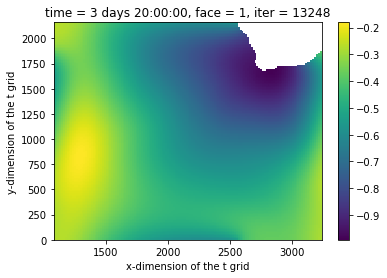

In [59]:
cor_fac = 15
eta_coarsened = eta.where(wet_mask.isel(time=20)>0).coarsen(i=cor_fac, j=cor_fac, boundary="pad").mean(keep_attrs=True)
wet_mask_coarsen = wet_mask.coarsen(i=cor_fac, j=cor_fac, boundary="pad").max(keep_attrs=True)

filter = gcm_filters.Filter(
    filter_scale=40,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask_coarsen.chunk({'i':-1,'j':-1,'time':1})}
)
filter
eta_filtered = filter.apply(eta_coarsened.chunk({'i':-1,'j':-1,'time':1}), dims=['i', 'j'])
eta_filtered.isel(time=20).plot(x='i')

In [60]:
eta_nobm = eta - eta_filtered.interp_like(eta.isel(time=20))

/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


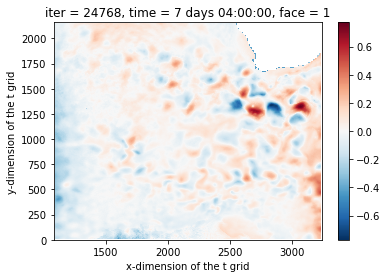

In [63]:
eta_nobm.isel(time=100).plot()

In [169]:
velmask = eta_nob.isel(time=0).where(np.isnan(eta_nob.isel(time=0)),1).where(np.isfinite(eta_nob.isel(time=0)),0)

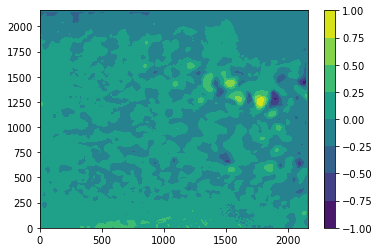

In [67]:
test = np.fromfile('/swot/SUM03/spencer/swot_eta_nobaro/eta_nobm.0000252000.data',dtype=np.dtype('>f4'))
cs=plt.contourf(test.reshape(2160,2160))
plt.colorbar(cs)

In [20]:
def output_binary_file(data, fname, dtype=np.dtype('>f4')):
    data.astype(dtype).tofile(fname)

In [ ]:
outdir='/swot/SUM03/spencer/swot_eta_nobaro/'
for i in range(0,1751):
    if np.mod(i,10)==0:
        print(i)
    nt = 10368 + i*144
    Nt = nt - 10368
    eta = eta_nobm.isel(time=i).fillna(0).values
    output_binary_file(eta, os.path.join(outdir, 'eta_nobm.%010d.data' % Nt))

In [68]:
Etatarget = '/swot/SUM02/spencer/swot_agulhas_surf/baro_nom.zarr'
for i in range(0,300):
    if np.mod(i,10)==0:
        print(i)
    eta_nobm_slice = eta_nobm.isel(time=[i])
    eta_nobm_slice.to_dataset(name='eta').to_zarr(Etatarget, append_dim='time')

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [41]:
source = zarr.open('/swot/SUM02/spencer/swot_agulhas_surf/eta_long.zarr')
intermediate = "/swot/SUM02/spencer/swot_agulhas_surf/intermediate.zarr"
target = "/swot/SUM02/spencer/swot_agulhas_surf/eta_timechunks.zarr"

In [42]:
target_chunks = {
    'Eta': {'time':1752,'j':180,'i':180},
    'x': {'i':180, 'j':180},
    'y': {'i':180, 'j':180},
    'time': None, # don't rechunk this array
    'iter': None,
    'i': None,
    'j': None,
}

In [43]:
rechunked = rechunk(source, target_chunks=target_chunks,target_store=target,max_mem='800MB',temp_store=intermediate)#, target_chunks={'i':180, 'j':180,'time':1751}, target_store=target,max_mem=256000,temp_store=intermediate)

In [44]:
rechunked.execute();

_copy_chunk((slice(0, 1371, None), slice(0, 270, None), slice(0, 540, None)))
_copy_chunk((slice(0, 1371, None), slice(0, 270, None), slice(540, 1080, None)))
_copy_chunk((slice(0, 1371, None), slice(0, 270, None), slice(1080, 1620, None)))
_copy_chunk((slice(0, 1371, None), slice(0, 270, None), slice(1620, 2160, None)))
_copy_chunk((slice(0, 1371, None), slice(270, 540, None), slice(0, 540, None)))
_copy_chunk((slice(0, 1371, None), slice(270, 540, None), slice(540, 1080, None)))
_copy_chunk((slice(0, 1371, None), slice(270, 540, None), slice(1080, 1620, None)))
_copy_chunk((slice(0, 1371, None), slice(270, 540, None), slice(1620, 2160, None)))
_copy_chunk((slice(0, 1371, None), slice(540, 810, None), slice(0, 540, None)))
_copy_chunk((slice(0, 1371, None), slice(540, 810, None), slice(540, 1080, None)))
_copy_chunk((slice(0, 1371, None), slice(540, 810, None), slice(1080, 1620, None)))
_copy_chunk((slice(0, 1371, None), slice(540, 810, None), slice(1620, 2160, None)))
_copy_chunk((sl

In [2]:
eta_timechunks = xr.open_zarr("/swot/SUM02/spencer/swot_agulhas_surf/eta_timechunks.zarr")

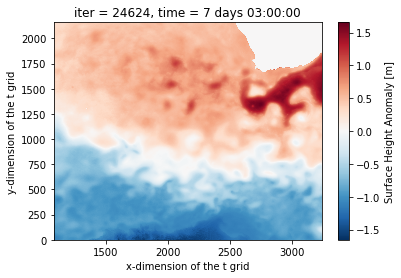

In [47]:
eta_timechunks.Eta.isel(time=100).plot()

In [50]:
eta_timechunks.Eta.time

<xarray.DataArray 'time' (time: 1752)>
array([           'NaT',  259200000000000,  262800000000000, ...,
       6552000000000000, 6555600000000000, 6559200000000000],
      dtype='timedelta64[ns]')
Coordinates:
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] NaT 3 days 00:00:00 ... 75 days 22:00:00
Attributes:
    axis:           T
    calendar:       gregorian
    long_name:      Time
    standard_name:  time

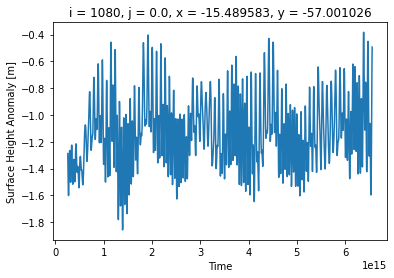

In [15]:
eta_timechunks.Eta.isel(time=slice(1,1752)).isel(i=0,j=0).plot()

In [22]:
eta_detrend = eta_timechunks.Eta.drop_vars('time') - eta_timechunks.Eta.drop_vars('time').rolling(time=24).mean()

In [23]:
eta_detrend.to_dataset(name='Eta').to_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_detrend.zarr')

In [3]:
eta_detrend = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_detrend.zarr').Eta

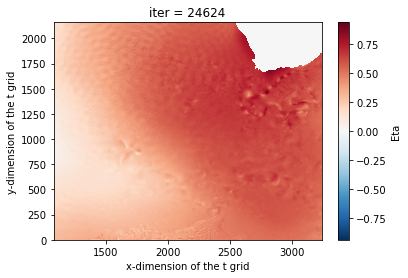

In [5]:
eta_detrend.isel(time=100).plot()

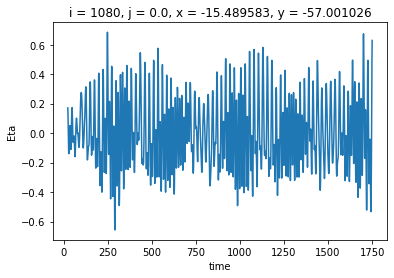

In [24]:
eta_detrend.isel(time=slice(1,1752)).isel(i=0,j=0).plot()

In [7]:
def sinusoid(time, a=0.004,b=0.18,c=1.3,d=-0.123,e=-0.18,f=0.14,g=-0.47,h=-0.15,k=-0.08,l=0.07,m=-0.93):
    return (a+b*np.sin(time*2*np.pi/12.42+c)+d*np.sin(time*2*np.pi/12+e)+f*np.sin(time*2*np.pi/23.92+g)+
        h*np.sin(time*2*np.pi/25.84+k)+l*np.sin(time*2*np.pi/12.66+m))

In [4]:
def sinusoid2(time, a=0.004,b=0.6,c=1.3,d=0.2,e=1.3):
    return (a+b*np.sin(time*2*np.pi/12.4213+c)+d*np.sin(time*2*np.pi/12+e))

In [8]:
for ii in range(0,216):
    print(ii)
    test_curvefit = eta_detrend.isel(i=slice(ii*10,ii*10+10),time=slice(48,-48)).curvefit('time',sinusoid2,skipna=False,
                                                                              bounds={"b": (0, 2),"d": (0, 2)})#
    test_curvefit.curvefit_coefficients.to_dataset().to_zarr('/swot/SUM02/spencer/swot_agulhas_surf/curvefit_coeffs.zarr',append_dim='i')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215


In [ ]:
#for ii in range(172,216):
#    print(ii)
#    test_curvefit = eta_detrend.isel(i=slice(ii*10,ii*10+10),time=slice(48,-48)).curvefit('time',sinusoid,skipna=False,
#                                                                              bounds={"b": (0, 1),"d": (0, 1),"f": (0, 1),"h": (0, 1),"l": (0, 1)})#
#    test_curvefit.curvefit_coefficients.to_dataset().to_zarr('/swot/SUM02/spencer/swot_agulhas_surf/curvefit_coeffs.zarr',append_dim='i')

172
173
174
175
176
177
178
179
180
181
182
183


In [5]:
coeffs = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/curvefit_coeffs.zarr').isel(i=slice(10,2170))

Text(0.5, 1.0, 'M2')

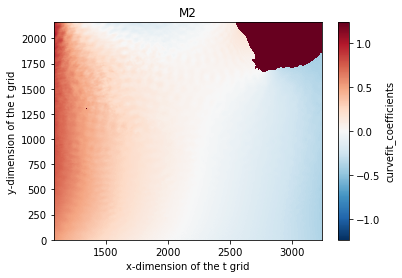

In [6]:

coeffs.sel(param='c').curvefit_coefficients.plot()
plt.title('M2')

In [28]:
coeffs.sel(param='c').curvefit_coefficients.isel(i=slice(0,1000),j=slice(0,1000)).mean().values

array(12.42127717)

KeyError: 'f'

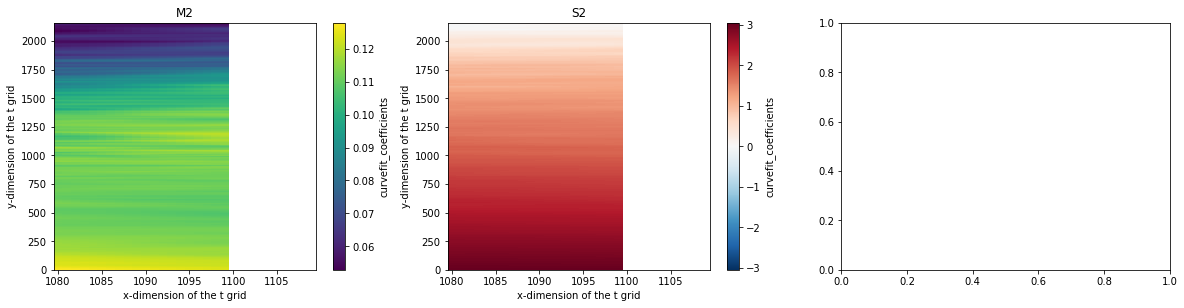

In [78]:
plt.figure(figsize=(20,10))

plt.subplot(231)
coeffs.sel(param='b').curvefit_coefficients.plot()
plt.title('M2')

plt.subplot(232)
coeffs.sel(param='d').curvefit_coefficients.plot()
plt.title('S2')

plt.subplot(233)
coeffs.sel(param='f').curvefit_coefficients.plot()
plt.title('K1')

plt.subplot(234)
coeffs.sel(param='h').curvefit_coefficients.plot()
plt.title('O1')

plt.subplot(235)
coeffs.sel(param='l').curvefit_coefficients.plot()
plt.title('N2')

fig=plt.gcf()

fig.savefig('explicit_fit.png')

In [157]:
from scipy.optimize import curve_fit

In [166]:
test_load = eta_detrend.isel(i=0,j=0,time=slice(48,-48)).load()

In [234]:
%%time
popt, pcov = curve_fit(sinusoid, test_load.time, 
                       test_load,
                       xtol=0.5,ftol=0.5)


CPU times: user 403 ms, sys: 18.3 ms, total: 421 ms
Wall time: 419 ms


In [34]:
coeffs.curvefit_coefficients.sel(param='a')

<xarray.DataArray 'curvefit_coefficients' (j: 2160, i: 1210)>
dask.array<getitem, shape=(2160, 1210), dtype=float64, chunksize=(180, 10), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 1080 1081 1082 1083 1084 ... 2285 2286 2287 2288 2289
  * j        (j) float64 0.0 1.0 2.0 3.0 ... 2.157e+03 2.158e+03 2.159e+03
    param    <U1 'a'
    x        (j, i) float32 dask.array<chunksize=(180, 170), meta=np.ndarray>
    y        (j, i) float32 dask.array<chunksize=(180, 170), meta=np.ndarray>

In [9]:
new_object=xr.DataArray(np.arange(0,1752),dims=['time'])
new_object = new_object*xr.ones_like(eta_detrend)

In [10]:
m2_est = xr.apply_ufunc(sinusoid2,new_object,coeffs.curvefit_coefficients.sel(param='a'),coeffs.curvefit_coefficients.sel(param='b'),
              coeffs.curvefit_coefficients.sel(param='c'),coeffs.curvefit_coefficients.sel(param='d')
                        ,coeffs.curvefit_coefficients.sel(param='e'),dask='allowed')

#m2_est = xr.apply_ufunc(sinusoid,new_object,coeffs.curvefit_coefficients.sel(param='a'),coeffs.curvefit_coefficients.sel(param='b'),
#              coeffs.curvefit_coefficients.sel(param='c'),coeffs.curvefit_coefficients.sel(param='d'),
#              coeffs.curvefit_coefficients.sel(param='e'),coeffs.curvefit_coefficients.sel(param='f'),
#              coeffs.curvefit_coefficients.sel(param='g'),coeffs.curvefit_coefficients.sel(param='h'),
#              coeffs.curvefit_coefficients.sel(param='k'),coeffs.curvefit_coefficients.sel(param='l'),
#              coeffs.curvefit_coefficients.sel(param='m'),dask='allowed')

In [15]:
m2_est.time

<xarray.DataArray 'time' (time: 1752)>
array([   0,    1,    2, ..., 1749, 1750, 1751])
Coordinates:
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: time

In [57]:
eta_detrend.isel(time=slice(48,2000))

<xarray.DataArray 'Eta' (time: 1704, j: 2160, i: 2160)>
dask.array<getitem, shape=(1704, 2160, 2160), dtype=float64, chunksize=(1704, 180, 180), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 1080 1081 1082 1083 1084 ... 3235 3236 3237 3238 3239
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * j        (j) float64 0.0 1.0 2.0 3.0 ... 2.157e+03 2.158e+03 2.159e+03
    x        (j, i) float32 dask.array<chunksize=(180, 180), meta=np.ndarray>
    y        (j, i) float32 dask.array<chunksize=(180, 180), meta=np.ndarray>
Dimensions without coordinates: time

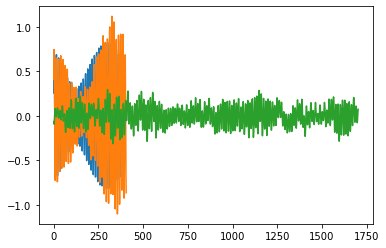

In [19]:
plt.plot(m2_est.isel(i=1000,j=1000,time=slice(0,400)))
plt.plot(eta_detrend.isel(i=1000,j=1000,time=slice(24,430)))
plt.plot((eta_detrend.isel(time=slice(48,2000))-m2_est.isel(time=slice(0,-48))).isel(i=1000,j=1000))

/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


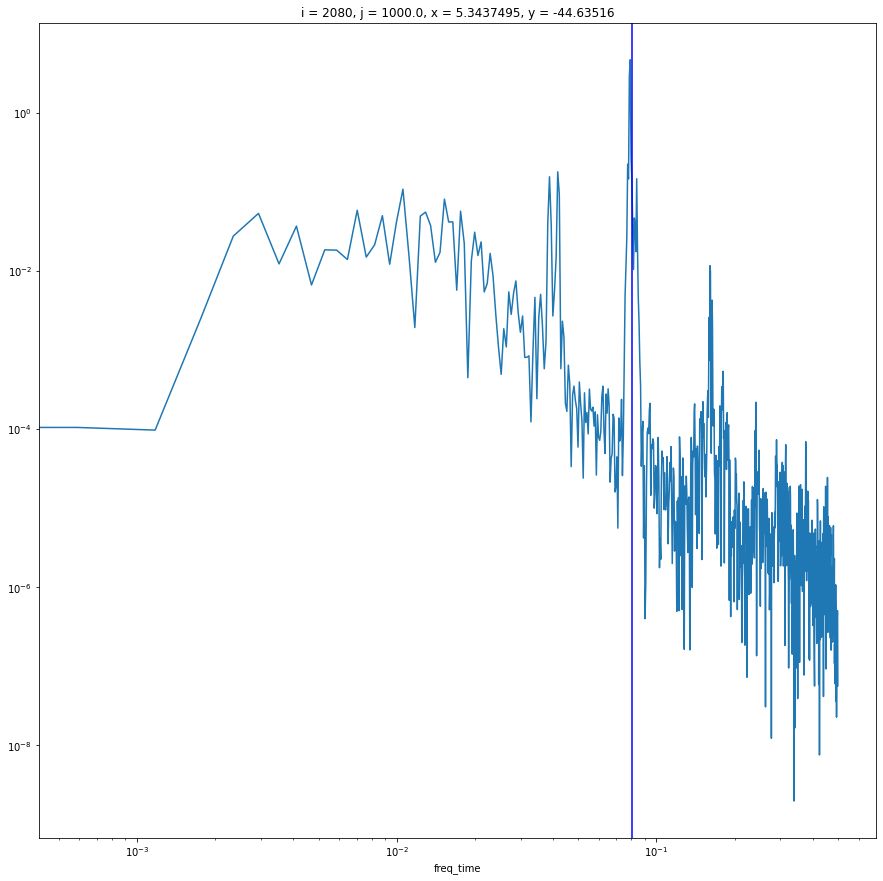

In [12]:
plt.figure(figsize=(15,15))
spect = xrft.power_spectrum((eta_detrend.isel(i=1000,j=1000,time=slice(48,2000))-m2_est.isel(i=1000,j=1000,time=slice(0,-48))),dim=['time'], window=True,window_correction=True).compute()
spect[1652//2:].plot()
plt.xscale('log')
plt.yscale('log')

#spect = xrft.power_spectrum((eta_detrend.isel(i=1000,j=1000,time=slice(100,2000))),dim=['time'], window=True,window_correction=True).compute()
#spect[1652//2:].plot()
plt.axvline([1/12.42],label='Semi-diurnal frequency',color='b')

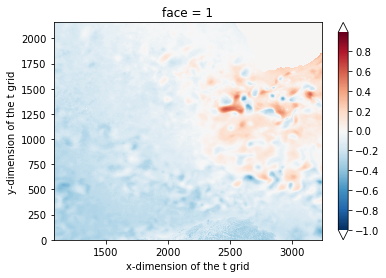

In [25]:
(eta_timechunks.Eta.drop_vars('time').isel(time=slice(48,2000))-m2_est.isel(time=slice(0,-48))-eta_mean).isel(time=1000).plot.pcolormesh(levels=np.arange(-1,1,0.01),rasterized=True,cbar_kwargs={'extend':'both'})


In [ ]:
plt.figure(figsize=(8,5))
for tt in range(1,300):
    plt.clf()
    (eta_timechunks.Eta.drop_vars('time').isel(time=slice(48,2000))-m2_est.isel(time=slice(0,-48))-eta_mean).isel(time=tt).plot.pcolormesh(levels=np.arange(-1,1,0.01),rasterized=True,cbar_kwargs={'extend':'both'})
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('time = ' + '{0:.2f}'.format((eta_timechunks.time.values[tt]-eta_timechunks.time.values[1]).item()/3600/24/10**9)+ 'days')
    plt.tight_layout()
    
    fig = plt.gcf()
    fig.savefig("/home/spencerj/agulhas-offline/movie/eta/fig{:03d}.jpg".format(tt))


In [33]:
eta_nobm_slice.time.attrs = {'axis': 'T',
 'calendar': 'gregorian',
 'long_name': 'Time',
 'standard_name': 'time'}

/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


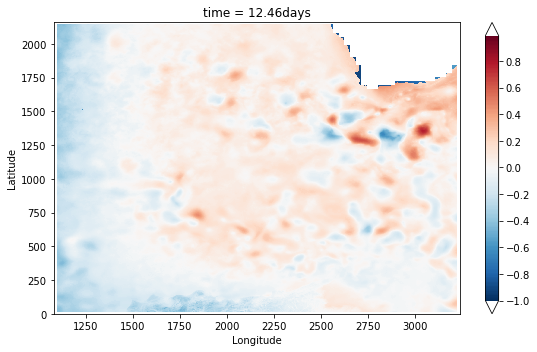

In [32]:
plt.figure(figsize=(8,5))
for tt in range(0,300):
    plt.clf()
    eta_nobm.isel(time=tt).plot.pcolormesh(levels=np.arange(-1,1,0.01),rasterized=True,cbar_kwargs={'extend':'both'})
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('time = ' + '{0:.2f}'.format((eta_merged.time.values[tt]-eta_merged.time.values[0])/3600/24)+ 'days')
    plt.tight_layout()
    
    fig = plt.gcf()
    fig.savefig("/home/spencerj/agulhas-offline/movie/eta/fig{:03d}.jpg".format(tt))

0


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


10


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


20


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


30


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


40


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


50


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


60


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


70


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


80


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


90


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


100


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


110


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


120


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


130


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


140


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


150


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


160


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


170


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


180


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


190


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


200


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


210


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


220


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


230


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


240


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


250


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


260


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


270


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


280


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


290


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


300


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


310


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


320


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


330


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


340


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


350


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


360


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


370


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


380


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


390


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


400


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


410


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


420


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


430


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


440


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


450


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


460


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


470


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


480


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


490


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


500


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


510


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


520


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


530


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


540


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


550


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


560


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


570


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


580


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


590


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


600


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


610


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


620


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


630


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


640


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


650


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


660


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


670


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


680


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


690


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


700


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


710


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


720


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


730


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


740


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


750


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


760


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


770


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


780


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


790


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


800


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


810


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


820


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


830


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


840


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


850


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


860


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


870


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


880


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


890


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


900


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


910


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


920


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


930


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


940


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


950


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


960


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


970


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


980


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


990


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1000


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1010


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1020


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1030


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1040


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1050


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1060


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1070


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1080


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1090


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1100


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1110


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1120


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1130


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1140


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1150


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1160


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1170


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1180


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1190


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1200


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1210


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1220


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1230


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1240


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1250


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1260


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1270


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1280


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1290


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1300


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1310


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1320


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1330


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1340


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1350


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1360


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1370


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1380


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1390


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1400


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1410


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1420


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1430


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1440


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1450


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1460


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1470


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1480


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1490


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1500


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1510


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1520


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1530


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1540


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1550


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1560


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1570


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1580


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1590


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1600


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1610


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1620


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1630


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1640


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1650


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1660


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1670


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1680


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1690


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1700


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1710


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1720


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1730


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1740


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1750


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [33]:
def lin_func(s, a=1, b=1, c=1):
    x,y=s
    return a * x+ b * y + c

In [59]:
fit_eta_unf = eta.where(eta.isel(time=20)!=0).chunk({'i':-1,'j':-1}).curvefit(["i","j"],func=lin_func,p0={"a":1,"b":1,"c":1})
fit_surface_unf = lin_func((eta.i,eta.j),fit_eta_unf.curvefit_coefficients.sel(param='a'), 
                       fit_eta_unf.curvefit_coefficients.sel(param='b'), fit_eta_unf.curvefit_coefficients.sel(param='c'))
eta_detr = (eta-fit_surface_unf.where((eta.isel(time=20)!=0)) )

/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/core.py:4337: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


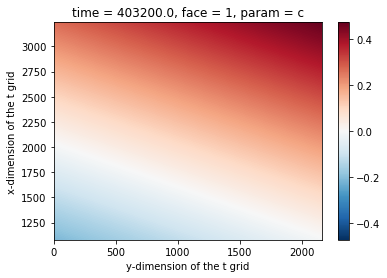

In [62]:
fit_surface_unf.isel(time=40).plot()

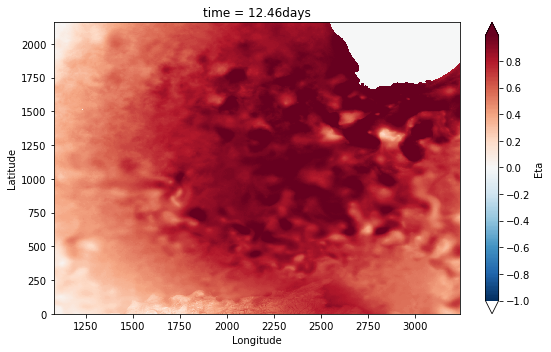

In [63]:
plt.figure(figsize=(8,5))
for tt in range(0,300):
    plt.clf()
    eta.isel(time=tt).plot.pcolormesh(levels=np.arange(-1,1,0.01),rasterized=True,cbar_kwargs={'extend':'both'})
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('time = ' + '{0:.2f}'.format((eta_merged.time.values[tt]-eta_merged.time.values[0])/3600/24)+ 'days')
    plt.tight_layout()
    
    fig = plt.gcf()
    fig.savefig("/home/spencerj/agulhas-offline/movie/eta/fig{:03d}.jpg".format(tt))

In [164]:
bathy = np.fromfile('/home/spencerj/agulhas-offline/input_agulhas/bathy_llc_4320_agulhas.bin',dtype='>f4').reshape(2160,2160)

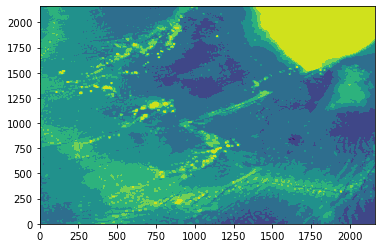

In [176]:
plt.contourf(bathy)

In [172]:
bathy2 = bathy*velmask.values
bathy2.astype('>f4').tofile('/home/spencerj/agulhas-offline/input_agulhas/bathymasked_ag.bin')

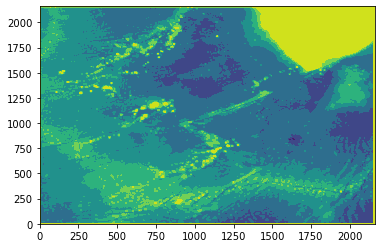

In [175]:
test = np.fromfile('/home/spencerj/agulhas-offline/input_agulhas/bathymasked_ag.bin',dtype='>f4').reshape(2160,2160)
plt.contourf(test)

In [ ]:
outdir='/swot/SUM03/spencer/swot_eta_nobaro/'
for i in range(0,1751):
    if np.mod(i,10)==0:
        print(i)
    nt = 10368 + i*144
    Nt = nt - 10368
    eta = eta_nob.isel(time=0).fillna(0).values
    output_binary_file(eta, os.path.join(outdir, 'eta_nob.%010d.data' % Nt))

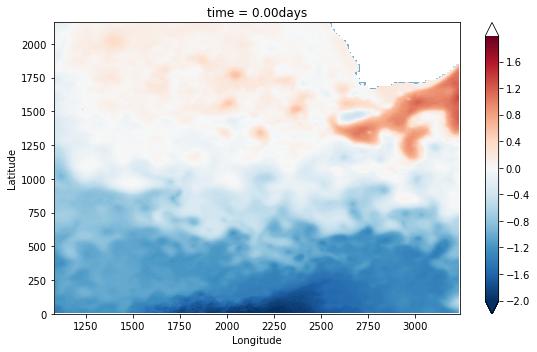

In [125]:
plt.figure(figsize=(8,5))
for tt in range(0,300):
    plt.clf()
    eta_nob.isel(time=tt).plot.pcolormesh(x='i',y='j',levels=np.arange(-2,2,0.01),rasterized=True,cbar_kwargs={'extend':'both'})
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('time = ' + '{0:.2f}'.format((eta_filtered.time.values[tt]-eta_filtered.time.values[0]).astype('f')/3600/24/10**9)+ 'days')
    plt.tight_layout()
    
    fig = plt.gcf()
    fig.savefig("/home/spencerj/agulhas-offline/movie/eta_filt/fig{:03d}.jpg".format(tt))

/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


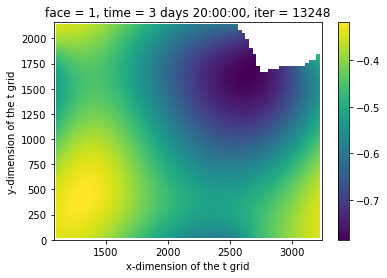

In [53]:
eta_filtered_mr.isel(time=20).interp_like(eta.isel(time=20)).plot(x='i')

In [12]:
eta_coarsened.j

<xarray.DataArray 'i' (i: 540)>
array([1081.5, 1085.5, 1089.5, ..., 3229.5, 3233.5, 3237.5])
Coordinates:
    face     int64 1
  * i        (i) float64 1.082e+03 1.086e+03 1.09e+03 ... 3.234e+03 3.238e+03
    iter     int64 10368
    time     timedelta64[ns] 3 days
Attributes:
    axis:           X
    long_name:      x-dimension of the t grid
    standard_name:  x_grid_index
    swap_dim:       XC

In [ ]:
outdir='/swot/SUM03/spencer/swot_trimmed/'
for i in range(0,5):
    if np.mod(i,10)==0:
        print(i)
    nt = 10368 + i*144
    Nt = nt - 10368
    ds = xr.open_dataset(indir + 'llc_4320_agulhas.%010d.nc' %nt)
    theta = ds.Theta[0].isel(k=slice(0,30)).values
    salt = ds.Salt[0].isel(k=slice(0,30)).values
    eta = ds.Eta[0].values
    uvel = ds.U[0].isel(k=slice(0,30)).values
    vvel = ds.V[0].isel(k=slice(0,30)).values
    #output_binary_file(theta, os.path.join(outdir, 'theta.%010d.data' % Nt))
    #output_binary_file(salt, os.path.join(outdir, 'salt.%010d.data' % Nt))
    #output_binary_file(eta, os.path.join(outdir, 'eta.%010d.data' % Nt))
    #output_binary_file(uvel, os.path.join(outdir, 'uvel.%010d.data' % Nt))
    #output_binary_file(vvel, os.path.join(outdir, 'vvel.%010d.data' % Nt))
    ds.close()

In [198]:
test1 = np.fromfile('/swot/SUM03/spencer/swot_eta_nobaro/eta_nob.0000252000.data',dtype='>f4')
test2 = np.fromfile('/swot/SUM03/spencer/swot_eta_nobaro/eta_nob.0000149904.data',dtype='>f4')

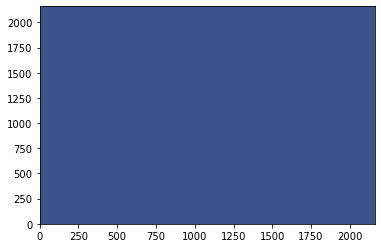

In [199]:
plt.contourf(test1.reshape(2160,2160)-test2.reshape(2160,2160))